In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
#import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
#plt.style.use(mplhep.style.CMS)

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']
sklearn: 0.23.2
tensorflow: 2.3.1


In [2]:
#tf.config.experimental.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    
print ( gpus )

[]


In [3]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

run_tables = False
train_model = True
learning_rate_scan = False
run_grid_search = True
save_model = True

scaler_path = ""
model_path = ""
if not train_model:
    scaler_path = "model/standard_scaler_test-multiRP_2021_01_22-17_27_08.joblib"
    model_path = "model/keras_model_test-multiRP_2021_01_22-17_46_10.h5"

{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Signal

In [4]:
label = "GGToWW-AQGC-A0W1e-6"

fileNames_signal = [
    "output-GGToWW-AQGC-A0W1e-6.h5"
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = get_data( fileNames_signal )
        df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = process_data_protons_multiRP( df_protons_multiRP_signal, df_ppstracks_signal, apply_fiducial=True, runOnMC=True )

        store_[ "counts" ] = df_counts_signal
        store_[ "protons_multiRP"] = df_protons_multiRP_signal_index
        store_[ "events_multiRP" ] = df_protons_multiRP_signal_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_signal = store_[ "counts" ]
    df_protons_multiRP_signal_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_signal_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/16 23:27:42
Total time elapsed: 0


In [5]:
df_protons_multiRP_signal_index[:20]

xi       thx       thy         t  ismultirp  \
run lumiblock event  slice                                                      
1   2266      226551 0      0.047449  0.000007  0.000021 -0.022129          1   
                     0      0.051457  0.000022  0.000089 -0.342805          1   
    2270      226932 0      0.032306  0.000006 -0.000075 -0.234367          1   
                     0      0.119526 -0.000012  0.000005 -0.020655          1   
    2273      227227 0      0.056667 -0.000025 -0.000072 -0.233687          1   
                     0      0.053138 -0.000011 -0.000024 -0.030825          1   
    2275      227457 0      0.068920 -0.000051  0.000024 -0.129756          1   
                     0      0.115064  0.000022  0.000018 -0.042887          1   
    2276      227546 0      0.090561 -0.000041  0.000076 -0.292089          1   
                     0      0.125299 -0.000021  0.000054 -0.142210          1   
              227579 0      0.118551 -0.000022 -0.000012 -0.037683          1   
                     0      0.169634 -0.000121 -0.000032 -0.583498          1   
    2281      228042 0      0.105618  0.000070  0.000014 -0.202386          1   
                     0      0.128394  0.000116  0.000039 -0.572105          1   
    2282      228117 0      0.037401  0.000059  0.000036 -0.195481          1   
                     0      0.058293  0.000015  0.000080 -0.266754          1   
    2286      228503 0      0.097616 -0.000020  0.000064 -0.181746          1   
                     0      0.106465  0.000008  0.000020 -0.027956          1   
              228565 0      0.088063 -0.000030  0.000009 -0.045153          1   
                     0      0.043299  0.000032  0.000032 -0.084826          1   

                            rpid  arm     jet0_pt  jet0_eta  jet0_phi  ...  \
run lumiblock event  slice                                             ...   
1   2266      226551 0       123    0  203.932037 -1.086163  0.536344  ...   
                     0       123    1  203.932037 -1.086163  0.536344  ...   
    2270      226932 0       123    0  320.698212 -1.370161 -1.832831  ...   
                     0       123    1  320.698212 -1.370161 -1.832831  ...   
    2273      227227 0       123    0  335.731934  0.259870 -3.108820  ...   
                     0       123    1  335.731934  0.259870 -3.108820  ...   
    2275      227457 0       123    0  345.850189 -1.458291  3.099098  ...   
                     0       123    1  345.850189 -1.458291  3.099098  ...   
    2276      227546 0       123    0  608.518616 -0.521754 -0.481351  ...   
                     0       123    1  608.518616 -0.521754 -0.481351  ...   
              227579 0       123    0  819.906433  0.347934  1.723913  ...   
                     0       123    1  819.906433  0.347934  1.723913  ...   
    2281      228042 0       123    0  764.408875 -0.631614  2.295349  ...   
                     0       123    1  764.408875 -0.631614  2.295349  ...   
    2282      228117 0       123    0  321.463196  0.091370 -2.196248  ...   
                     0       123    1  321.463196  0.091370 -2.196248  ...   
    2286      228503 0       123    0  649.005920 -0.110481  1.066668  ...   
                     0       123    1  649.005920 -0.110481  1.066668  ...   
              228565 0       123    0  360.785767  0.943119 -1.373860  ...   
                     0       123    1  360.785767  0.943119 -1.373860  ...   

                            yhigh  eff_all_weighted  eff_all_2017B  \
run lumiblock event  slice                                           
1   2266      226551 0      4.298          0.339100       0.465410   
                     0      4.698          0.413233       0.450737   
    2270      226932 0      4.298          0.218844       0.389240   
                     0      4.698          0.427809       0.469562   
    2273      227227 0      4.298          0.340731       0.461063   
                     0      4.698          0

In [6]:
df_protons_multiRP_signal_events[:20]

jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   2266      226551 0      203.932037 -1.086163  0.536344   341.780396   
    2270      226932 0      320.698212 -1.370161 -1.832831   676.274719   
    2273      227227 0      335.731934  0.259870 -3.108820   362.594666   
    2275      227457 0      345.850189 -1.458291  3.099098   789.123108   
    2276      227546 0      608.518616 -0.521754 -0.481351   700.701050   
              227579 0      819.906433  0.347934  1.723913   876.879761   
    2281      228042 0      764.408875 -0.631614  2.295349   931.069336   
    2282      228117 0      321.463196  0.091370 -2.196248   340.011597   
    2286      228503 0      649.005920 -0.110481  1.066668   663.828003   
              228565 0      360.785767  0.943119 -1.373860   543.946289   
    2289      228803 0      553.738098 -0.434034  1.881415   614.260864   
    2291      229042 0      226.409943 -1.545674 -2.217598   557.465759   
    2296      229520 0      359.400543  1.004407  1.754919   563.566833   
    2297      229605 0      314.089844 -0.833665  2.804024   440.285126   
    2298      229715 0      303.292603 -0.605599  1.378168   376.307190   
    2299      229845 0      477.458221  0.370481  2.630056   518.588989   
              229840 0      320.155548 -1.622710  1.047925   847.165649   
    2301      230059 0      441.006378  0.965674 -0.766519   669.868591   
    2302      230119 0      798.193726  0.189021 -1.469288   819.300537   
              230195 0      544.700195  1.061919  1.596644   887.435242   

                            jet0_mass  jet0_corrmass  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                                   
1   2266      226551 0      12.367921      13.346299   0.195710   0.150335   
    2270      226932 0      14.117490      15.467690   0.133448   0.087425   
    2273      227227 0      76.227875      80.442612   0.267451   0.157171   
    2275      227457 0      65.536522      72.338219   0.233271   0.122797   
    2276      227546 0      72.550140      76.958649   0.172939   0.069660   
              227579 0      71.808578      75.820915   0.110508   0.028728   
    2281      228042 0      79.922424      84.708092   0.132495   0.041123   
    2282      228117 0      82.721222      87.231079   0.315415   0.074349   
    2286      228503 0      74.978531      79.055267   0.136293   0.045175   
              228565 0      77.647881      82.982536   0.313472   0.088111   
    2289      228803 0      44.962955      47.573677   0.107484   0.078630   
    2291      229042 0      11.176210      12.146883   0.124646   0.086952   
    2296      229520 0      35.827625      38.593582   0.147956   0.106880   
    2297      229605 0      83.700836      89.312263   0.238683   0.113802   
    2298      229715 0      70.477509      74.703987   0.361345   0.191824   
    2299      229845 0      64.603653      68.314133   0.146203   0.045197   
              229840 0      59.823513      63.107220   0.261954   0.129281   
    2301      230059 0      71.749168      77.266960   0.216342   0.052447   
    2302      230119 0      69.325928      72.965050   0.066868   0.028144   
              230195 0      61.842346      67.256874   0.107923   0.052825   

                            jet0_vertexz    muon0_pt  ...   xhigh    ylow  \
run lumiblock event  slice                            ...                   
1   2266      226551 0               0.0  120.215347  ...  24.334 -10.098   
    2270      226932 0               0.0  318.476288  ...  24.334 -10.098   
    2273      227227 0               0.0   59.688713  ...  24.334 -10.098   
    2275      227457 0               0.0  299.653168  ...  24.334 -10.098   
    2276      227546 0               0.0  563.565247  ...  24.334 -10.098   
              227579 0               0.0  263.500122  ...  24.334 -10.098   
    2281      228042 0               0.0  171.4

### Background

In [7]:
resample_factor = 20
label = "data-random-resample_20"

fileNames_bkg = [
    "output-data-random-resample_20-2017B.h5",
    "output-data-random-resample_20-2017C.h5",
    "output-data-random-resample_20-2017D.h5",
    "output-data-random-resample_20-2017E.h5",
    "output-data-random-resample_20-2017F.h5"
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = 4 * [None]
df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = 3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = get_data( fileNames_bkg )
        df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = process_data_protons_multiRP( df_protons_multiRP_bkg, df_ppstracks_bkg, apply_fiducial=True, within_aperture=True, random_protons=True, runOnMC=False )

        store_[ "counts" ] = df_counts_bkg
        store_[ "protons_multiRP"] = df_protons_multiRP_bkg_index
        store_[ "events_multiRP" ] = df_protons_multiRP_bkg_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_bkg = store_[ "counts" ]
    df_protons_multiRP_bkg_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_bkg_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/16 23:28:01
Total time elapsed: 16


In [8]:
df_protons_multiRP_bkg_index[:20]

xi       thx       thy         t  \
run    lumiblock event     slice                                           
297101 216       302550016 0      0.053462  0.000038 -0.000089 -0.375001   
                           0      0.108715  0.000028 -0.000071 -0.232221   
297292 87        162028576 0      0.041559  0.000090  0.000020 -0.347821   
                           0      0.078012  0.000043 -0.000074 -0.290854   
297050 23        23347598  0      0.039482 -0.000016 -0.000056 -0.137540   
                           0      0.070625  0.000103  0.000083 -0.692292   
       65        78788008  0      0.094874 -0.000006 -0.000094 -0.349458   
                           0      0.088130  0.000026 -0.000054 -0.144942   
       499       605989248 0      0.046020  0.000002  0.000030 -0.037710   
                           0      0.044068  0.000065 -0.000112 -0.680873   
297411 315       507722016 0      0.115323 -0.000139 -0.000009 -0.740176   
                           0      0.084233 -0.000093  0.000012 -0.349463   
       377       608603776 0      0.036584 -0.000039 -0.000136 -0.817616   
                           0      0.045994  0.000036 -0.000064 -0.218576   
297177 103       155861312 0      0.098408 -0.000010 -0.000046 -0.094515   
                           0      0.041949 -0.000018  0.000023 -0.036352   
       112       168879968 0      0.031520  0.000010 -0.000105 -0.458029   
                           0      0.082399  0.000013 -0.000029 -0.044631   
297057 359       451236608 0      0.106113  0.000021  0.000082 -0.282647   
                           0      0.121658 -0.000046  0.000034 -0.137009   

                                  ismultirp  rpid  arm     jet0_pt  jet0_eta  \
run    lumiblock event     slice                                               
297101 216       302550016 0              1   123    0  253.968201 -0.707324   
                           0              1   123    1  253.968201 -0.707324   
297292 87        162028576 0              1   123    0  211.335602  0.778516   
                           0              1   123    1  211.335602  0.778516   
297050 23        23347598  0              1   123    0  261.334717 -1.010473   
                           0              1   123    1  261.334717 -1.010473   
       65        78788008  0              1   123    0  223.571411 -0.640955   
                           0              1   123    1  223.571411 -0.640955   
       499       605989248 0              1   123    0  247.993744 -0.750684   
                           0              1   123    1  247.993744 -0.750684   
297411 315       507722016 0              1   123    0  202.485367 -1.909996   
                           0              1   123    1  202.485367 -1.909996   
       377       608603776 0              1   123    0  241.069107 -0.283513   
                           0              1   123    1  241.069107 -0.283513   
297177 103       155861312 0              1   123    0  205.575821  1.169397   
                           0              1   123    1  205.575821  1.169397   
       112       168879968 0              1   123    0  249.287399 -0.463456   
                           0              1   123    1  249.287399 -0.463456   
297057 359       451236608 0              1   123    0  394.285278  0.398574   
                           0              1   123    1  394.285278  0.398574   

                                  jet0_phi  ...    trackx2   tracky2  \
run    lumiblock event     slice            ...                        
297101 216       302550016 0      2.950644  ...   5.739746  1.239502   
                           0      2.950644  ...   8.485718  4.192871   
297292 87        162028576 0     -2.783820  ...   4.923218 -0.440033   
                           0     -2.783820  ...   6.192932  2.448730   
297050 23        23347598  0      1.135294  ...   3.563660  0.499451   
                           0      1.135294  ...   6.810974 -2.298340   
       65        78788008  0  

In [9]:
df_protons_multiRP_bkg_events[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297101 216       302550016  0      253.968201 -0.707324  2.950644   
297292 87        162028576  0      211.335602  0.778516 -2.783820   
297050 23        23347598   0      261.334717 -1.010473  1.135294   
       65        78788008   0      223.571411 -0.640955 -1.560675   
       499       605989248  0      247.993744 -0.750684 -1.880714   
297411 315       507722016  0      202.485367 -1.909996 -2.974470   
       377       608603776  0      241.069107 -0.283513  2.425223   
297177 103       155861312  0      205.575821  1.169397 -2.365454   
       112       168879968  0      249.287399 -0.463456  0.465937   
297057 359       451236608  0      394.285278  0.398574 -1.529445   
297219 2173      3099827968 0      288.619812  0.455739  0.454244   
                 3099778304 0      375.724274  0.520944 -0.466679   
                 3100205568 0      247.402695 -1.569887  0.242396   
297425 58        92710800   0      456.756805 -0.825246  1.224345   
297050 640       759692672  0      356.842926 -1.857062  1.034243   
       658       778318912  0      323.938354 -2.283609  2.840562   
       633       752294720  0      281.741394  1.049507  3.116731   
                 752405312  0      203.592255 -1.403587  1.493702   
       635       754300416  0      278.962280  2.154710 -2.295970   
       634       753442816  0      460.727081  1.591670  1.678488   

                                   jet0_energy   jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                           
297101 216       302550016  0       333.493073   79.504433      85.812309   
297292 87        162028576  0       282.520508   32.382271      34.919926   
297050 23        23347598   0       412.250397   26.409565      28.783287   
       65        78788008   0       276.403442   11.500848      12.381974   
       499       605989248  0       327.492065   37.604755      40.593559   
297411 315       507722016  0       701.777527   37.559608      42.359814   
       377       608603776  0       259.671875   16.288521      17.486908   
297177 103       155861312  0       367.820312   34.211136      38.303947   
       112       168879968  0       284.730316   20.713552      22.339268   
297057 359       451236608  0       453.403381  138.037384     148.165756   
297219 2173      3099827968 0       328.551727   69.199577      74.361023   
                 3099778304 0       431.490173    6.786267       7.290971   
                 3100205568 0       622.208618   11.449527      12.662539   
297425 58        92710800   0       627.350525   17.468006      18.844810   
297050 640       759692672  0      1173.785034   22.226070      24.627333   
       658       778318912  0      1607.517578   16.241558      18.127111   
       633       752294720  0       461.690247   82.215797      90.832924   
                 752405312  0       447.180359   62.394794      70.382645   
       635       754300416  0      1224.405396   78.443649      88.524498   
       634       753442816  0      1189.134033  133.705704     146.878067   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297101 216       302550016  0       0.362731   0.066945           0.0   
297292 87        162028576  0       0.129498   0.093096           0.0   
297050 23        23347598   0       0.201263   0.162387           0.0   
       65        78788008   0       0.134743   0.108764           0.0   
       499       605989248  0       0.186229   0.143760           0.0   
297411 315       507722016  0       0.238960   0.180407           0.0   
       377       608603776  0       0.193646   0.163281           0.0   
297177 103       155861312  0       0.272831   0.143435           0.0   
       112       168879968  0       0.206549   0.140903           0.0   
297057 359       4512

### Select events

In [10]:
msk_bkg = ( ( df_protons_multiRP_bkg_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
            ( df_protons_multiRP_bkg_events.loc[ :, "jet0_corrmass"] <= 110.0 ) & 
            ( df_protons_multiRP_bkg_events.loc[ :, "num_bjets_ak4"] == 0 ) )
msk_signal = ( ( df_protons_multiRP_signal_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
               ( df_protons_multiRP_signal_events.loc[ :, "jet0_corrmass"] <= 110.0 ) &
               ( df_protons_multiRP_signal_events.loc[ :, "num_bjets_ak4"] == 0 ) )
df_protons_multiRP_bkg_events = df_protons_multiRP_bkg_events.loc[ msk_bkg ]
df_protons_multiRP_signal_events = df_protons_multiRP_signal_events.loc[ msk_signal ]

### Set aside test sample

In [11]:
from sklearn.model_selection import train_test_split

y_sig_ = np.ones( df_protons_multiRP_signal_events.shape[0] )
y_bkg_ = np.zeros( df_protons_multiRP_bkg_events.shape[0] )

df_protons_multiRP_signal_train, df_protons_multiRP_signal_test, y_sig_train, y_sig_test = train_test_split( df_protons_multiRP_signal_events, y_sig_, test_size=0.40, shuffle=True, random_state=12345 )
df_protons_multiRP_bkg_train, df_protons_multiRP_bkg_test, y_bkg_train, y_bkg_test = train_test_split( df_protons_multiRP_bkg_events, y_bkg_, test_size=0.40, shuffle=True, random_state=12345 )

print ( df_protons_multiRP_signal_train, df_protons_multiRP_signal_test, y_sig_train, y_sig_test )
print ( df_protons_multiRP_bkg_train, df_protons_multiRP_bkg_test, y_bkg_train, y_bkg_test )

                               jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   692       69165  0      446.589264 -0.209196  2.348332   467.058716   
    712       71170  0      216.072113 -1.208501 -3.120574   403.781769   
    1131      113051 0      247.025314 -1.259652 -2.274014   480.067902   
    9896      489556 0      320.552094 -1.077433 -1.097454   535.666321   
    5494      49311  0      440.465118  1.148309  0.904640   771.395386   
    8827      382682 0      786.602600  0.062801 -1.159230   797.403320   
    3977      397601 0      937.875610 -0.184862  2.552135   971.249695   
    4860      485950 0      299.527618  1.506294 -2.951234   716.084167   
    5486      48571  0      308.901978 -0.944830  0.195862   466.164368   
    183       18269  0      475.133240  1.268287  2.724869   918.176941   
    5567      56668  0      228.259064  1.207786 -2.425200   423.454651   
    9108      410714 0   

In [12]:
print ( [ arr_.shape[0] for arr_ in ( df_protons_multiRP_signal_train, df_protons_multiRP_signal_test, y_sig_train, y_sig_test ) ] )
print ( [ arr_.shape[0] for arr_ in ( df_protons_multiRP_bkg_train, df_protons_multiRP_bkg_test, y_bkg_train, y_bkg_test ) ] )
print ( df_protons_multiRP_signal_test.mean() )
print ( df_protons_multiRP_bkg_test.mean() )

[1590, 1061, 1590, 1061]
[109249, 72833, 109249, 72833]
jet0_pt                    428.850272
jet0_eta                    -0.149090
jet0_phi                     0.058497
jet0_energy                570.372019
jet0_mass                   74.376918
jet0_corrmass               79.203663
jet0_tau1                    0.239439
jet0_tau2                    0.094261
jet0_vertexz                 0.000000
muon0_pt                   223.413035
muon0_eta                   -0.049471
muon0_phi                   -0.009195
muon0_energy               295.272954
muon0_charge                -0.014138
muon0_iso                    0.003828
muon0_dxy                    0.000620
muon0_dz                     0.002007
met                        194.596232
met_x                      -13.052421
met_y                       -2.097455
met_phi                      0.028091
nVertices                   29.796418
num_bjets_ak8                0.014138
num_bjets_ak4                0.000000
num_jets_ak4                 0.1

### Select variables

In [16]:
variables_ = [ 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'muon0_pt', 'muon0_eta', 'muon0_phi', 'met', 'met_phi',
               'pfcand_nextracks', 'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]
# variables_ = [ 'jet0_pt', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'pfcand_nextracks', 
#                'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]

n_events_signal = None
X_sig_train = None
if n_events_signal:
    X_sig_train = df_protons_multiRP_signal_train[ variables_ ].iloc[:n_events_signal]
    y_sig_train = y_sig_train.iloc[:n_events_signal]
else:
    X_sig_train = df_protons_multiRP_signal_train[ variables_ ]
print ( X_sig_train.shape )
print ( X_sig_train[:20] )

X_sig_test = df_protons_multiRP_signal_test[ variables_ ]

n_events_bkg = None
# n_events_bkg = 100000
X_bkg_train = None
if n_events_bkg:
    X_bkg_train = df_protons_multiRP_bkg_train[ variables_ ].iloc[:n_events_bkg]
    y_bkg_train = y_bkg_train.iloc[:n_events_bkg]
else:
    X_bkg_train = df_protons_multiRP_bkg_train[ variables_ ]
print ( X_bkg_train.shape )
print ( X_bkg_train[:20] )

X_bkg_test = df_protons_multiRP_bkg_test[ variables_ ]

# y_sig = np.ones( len(X_sig) )
# y_bkg = np.zeros( len(X_bkg) )

# X = pd.concat( [X_sig, X_bkg] ) 
# y = np.concatenate( [y_sig, y_bkg] )

# from sklearn.model_selection import train_test_split
# X_train_full, X_test, y_train_full, y_test = train_test_split( X, y, test_size=0.20, shuffle=True, random_state=42 )
# X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full, test_size=0.20, shuffle=False )

X_ = pd.concat( [X_sig_train, X_bkg_train] ) 
y_ = np.concatenate( [y_sig_train, y_bkg_train] )

X_train, X_valid, y_train, y_valid = train_test_split( X_, y_, test_size=0.20, shuffle=True, random_state=42 )

(1590, 17)
                               jet0_pt  jet0_eta  jet0_phi  jet0_tau1  \
run lumiblock event  slice                                              
1   692       69165  0      446.589264 -0.209196  2.348332   0.190537   
    712       71170  0      216.072113 -1.208501 -3.120574   0.376304   
    1131      113051 0      247.025314 -1.259652 -2.274014   0.374800   
    9896      489556 0      320.552094 -1.077433 -1.097454   0.236626   
    5494      49311  0      440.465118  1.148309  0.904640   0.241114   
    8827      382682 0      786.602600  0.062801 -1.159230   0.149467   
    3977      397601 0      937.875610 -0.184862  2.552135   0.133032   
    4860      485950 0      299.527618  1.506294 -2.951234   0.328798   
    5486      48571  0      308.901978 -0.944830  0.195862   0.332621   
    183       18269  0      475.133240  1.268287  2.724869   0.166209   
    5567      56668  0      228.259064  1.207786 -2.425200   0.370347   
    9108      410714 0      758.811890  

In [17]:
X_train

,,,,jet0_pt,jet0_eta,jet0_phi,jet0_tau1,jet0_tau2,muon0_pt,muon0_eta,muon0_phi,met,met_phi,pfcand_nextracks,WLeptonicPt,WLeptonicPhi,recoMWW,recoRapidityWW,MX,YX
run,lumiblock,event,slice,,,,,,,,,,,,,,,,,
300633,415,626154560,9,208.840973,0.302073,-1.260890,0.460791,0.205677,128.848465,0.734502,2.093632,62.422356,3.034743,77,173.122498,2.389338,417.919556,0.485716,1116.208374,-0.218856
305586,187,280768480,13,358.769135,-0.623563,1.603158,0.302386,0.098109,87.050537,-0.940705,-1.835948,226.123978,-1.360350,60,306.119476,-1.490924,691.092163,-0.647967,925.487915,0.099943
305377,395,719541184,14,354.781860,0.903452,2.203609,0.146299,0.072572,53.385918,-0.924630,0.034733,20.233953,-0.385401,36,72.332588,-0.079615,431.293793,0.596363,1037.926025,-0.293819
305207,567,879608704,9,450.644501,1.821774,-0.440118,0.294301,0.096640,117.843414,1.724970,2.698297,260.595093,3.016479,25,374.343201,2.917836,852.773621,1.655106,688.492798,0.060082
302225,110,71405488,14,318.615356,0.470060,-1.915806,0.366643,0.134348,86.470970,0.608403,0.820409,181.660324,1.230284,39,263.234070,1.099004,611.432617,0.369854,817.976990,-0.386938
305112,402,657740480,19,249.752197,-0.588985,3.092702,0.296870,0.185908,160.000137,-1.724023,0.236858,116.523087,-0.006028,56,274.537109,0.134601,614.072205,-1.041568,1026.490112,0.087748
302322,216,171422112,3,373.926331,-1.830475,-0.722380,0.189993,0.095441,85.895691,0.675169,1.967663,74.578400,2.404937,50,156.674133,2.170626,823.041626,-1.063657,924.268188,0.353504
301391,171,149952512,8,275.996735,-1.927359,-0.260354,0.345613,0.107494,117.863052,-2.008181,2.537637,155.511719,3.081792,26,263.512939,2.848118,568.651001,-1.867158,806.197510,0.408274
302448,269,320619872,15,268.252716,-0.003774,0.992914,0.372034,0.096143,62.028652,1.949143,-2.010168,64.404228,-2.311002,56,125.005791,-2.163432,515.184631,0.482153,750.180176,-0.197054


In [19]:
X_test = pd.concat( [X_sig_test, X_bkg_test] ) 
y_test = np.concatenate( [y_sig_test, y_bkg_test] )

In [20]:
X_test

jet0_pt  jet0_eta  jet0_phi  jet0_tau1  \
run    lumiblock event      slice                                              
1      2932      293183     0      726.249329 -0.431852 -2.216155   0.118523   
       4803      480215     0      337.461212 -1.137929 -2.241534   0.284493   
       2787      278676     0      229.666183 -0.564687 -2.069378   0.237553   
       9213      421278     0      276.224945  0.431582 -3.116563   0.355410   
       8908      390796     0      613.419373  0.455190  2.967290   0.132120   
       3283      328268     0      374.292419 -0.453391  2.726436   0.158634   
       9975      497456     0      224.421371 -1.966404 -3.006881   0.476983   
       8262      326149     0      769.035889 -0.616593  2.146009   0.102224   
       9080      407918     0      239.066650  0.435802 -0.340146   0.393581   
       683       68267      0      626.219727  0.331274 -0.767480   0.169769   
       819       81832      0      396.377136  0.161149 -1.585535   0.207577   
       3593      359281     0      231.438248 -0.680751 -2.068959   0.395637   
       9453      445271     0      325.453766 -0.800258 -2.538819   0.296233   
       1929      192873     0      246.676376  1.239440 -1.225662   0.393098   
       686       68594      0      482.831665  0.598066 -2.030462   0.225956   
       2910      290903     0      521.336182  0.510899  0.640092   0.175169   
       8548      354706     0      448.681335 -1.241759 -1.370711   0.271813   
       9320      431912     0      335.927399  0.956402  0.633629   0.282624   
       2734      273367     0      344.666321  0.829135  2.988293   0.246271   
       473       47227      0      672.694580  0.288613 -1.078553   0.133587   
       9084      408308     0      222.487900  0.828301 -3.049489   0.199818   
       8939      393888     0      234.131134  1.390597  1.268082   0.341147   
       3484      348320     0      365.873627 -0.928817 -1.560967   0.184263   
       985       98464      0      554.344543  0.011523 -0.562769   0.130882   
       9935      493405     0      587.169434  0.919221 -2.356461   0.123168   
       50        4970       0      292.433563 -0.290050  1.114068   0.208561   
       9166      416507     0      258.621826  1.253222 -2.065940   0.420786   
       5223      22281      0      320.348267 -1.723126  1.188467   0.320916   
       1785      178442     0      460.503754 -0.331867 -0.290791   0.208749   
       4775      477402     0      502.512604  0.550479  1.013906   0.151248   
...                                       ...       ...       ...        ...   
305440 163       270055200  15     238.720963  0.256053 -0.774830   0.238696   
306125 628       1127786240 7      216.093216 -0.676660 -2.737888   0.256309   
302634 183       207429936  4      215.977524  0.064848 -2.543337   0.308507   
304625 399       588490496  8      275.162292 -0.983976 -0.886280   0.157313   
305237 581       1085251712 6      270.311890  1.248275 -1.693924   0.269546   
305518 1032      1647445888 7      222.007111  0.847810 -0.591690   0.484121   
302131 237       205921616  1      221.670135  1.195414 -2.359515   0.332188   
306420 33        51902824   8      246.415390 -0.828952 -0.458233   0.353185   
300636 1382      1581703936 10     285.639252 -1.762396 -1.810227   0.218786   
300576 888       1292128128 5      216.227371  1.378346  0.699002   0.417351   
305636 150       199687728  16     203.418900 -1.209829  1.122682   0.255289   
300280 487       630822848  5      502.931946 -0.580292 -0.709444   0.185966   
305406 792       1430401920 12     217.005737 -0.635639  0.648541   0.417232   
305377 1311      2314738944 2      211.910019 -0.595330  3.066189   0.270946   
300560 39        47088896   18     272.013763  0.513900  2.248284   0.367765   
306423 292       528822016  10     229.543549 -0.816321 -1.230114   0.337356   
297219 1160      1953740288 7      233.407669  1.643435 -1.065538   0.363833   
302485 661       765252224  1      228

In [21]:
np.sum( y_train == 1 ) / y_train.size

0.014040667185438305

In [22]:
np.sum( y_valid == 1 ) / y_valid.size

0.015562973655719957

In [23]:
np.sum( y_test == 1 ) / y_test.size

0.014358405283243565

### Scale inputs

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train_scaled = None
if train_model:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform( X_train )
else:
    scaler = load( scaler_path )
    X_train_scaled = scaler.transform( X_train )
    
X_valid_scaled = scaler.transform( X_valid )
X_test_scaled = scaler.transform( X_test )

print ( scaler )

if train_model and save_model:
    dump( scaler, "model/standard_scaler.joblib")

StandardScaler()


In [27]:
X_train_scaled[:20]

array([[-7.66966278e-01,  2.87424319e-01, -6.85661832e-01,
         1.83682886e+00,  9.40803927e-01, -1.62503394e-02,
         6.19796090e-01,  1.14546496e+00, -4.44716871e-01,
         1.63877389e+00,  1.61671333e+00, -3.60270435e-01,
         1.29632944e+00, -7.67962235e-01,  5.71486051e-01,
         3.95189527e-01, -5.29951661e-01],
       [ 1.16559428e+00, -5.49537804e-01,  8.98445620e-01,
         9.10784338e-03, -1.18878923e+00, -5.90671073e-01,
        -7.88738184e-01, -1.00861036e+00,  1.77474667e+00,
        -7.54802048e-01,  7.96029863e-01,  9.83638458e-01,
        -8.26176851e-01,  4.01593828e-01, -7.38026783e-01,
        -3.31440356e-01,  7.01958841e-01],
       [ 1.11419868e+00,  8.31192860e-01,  1.23055564e+00,
        -1.79187126e+00, -1.69436219e+00, -1.05331734e+00,
        -7.75222618e-01,  1.68397061e-02, -1.01670644e+00,
        -2.23843026e-01, -3.62582085e-01, -1.37873309e+00,
        -5.41896058e-02, -7.10702028e-01,  6.99294179e-01,
         9.69399621e-02, -8.1

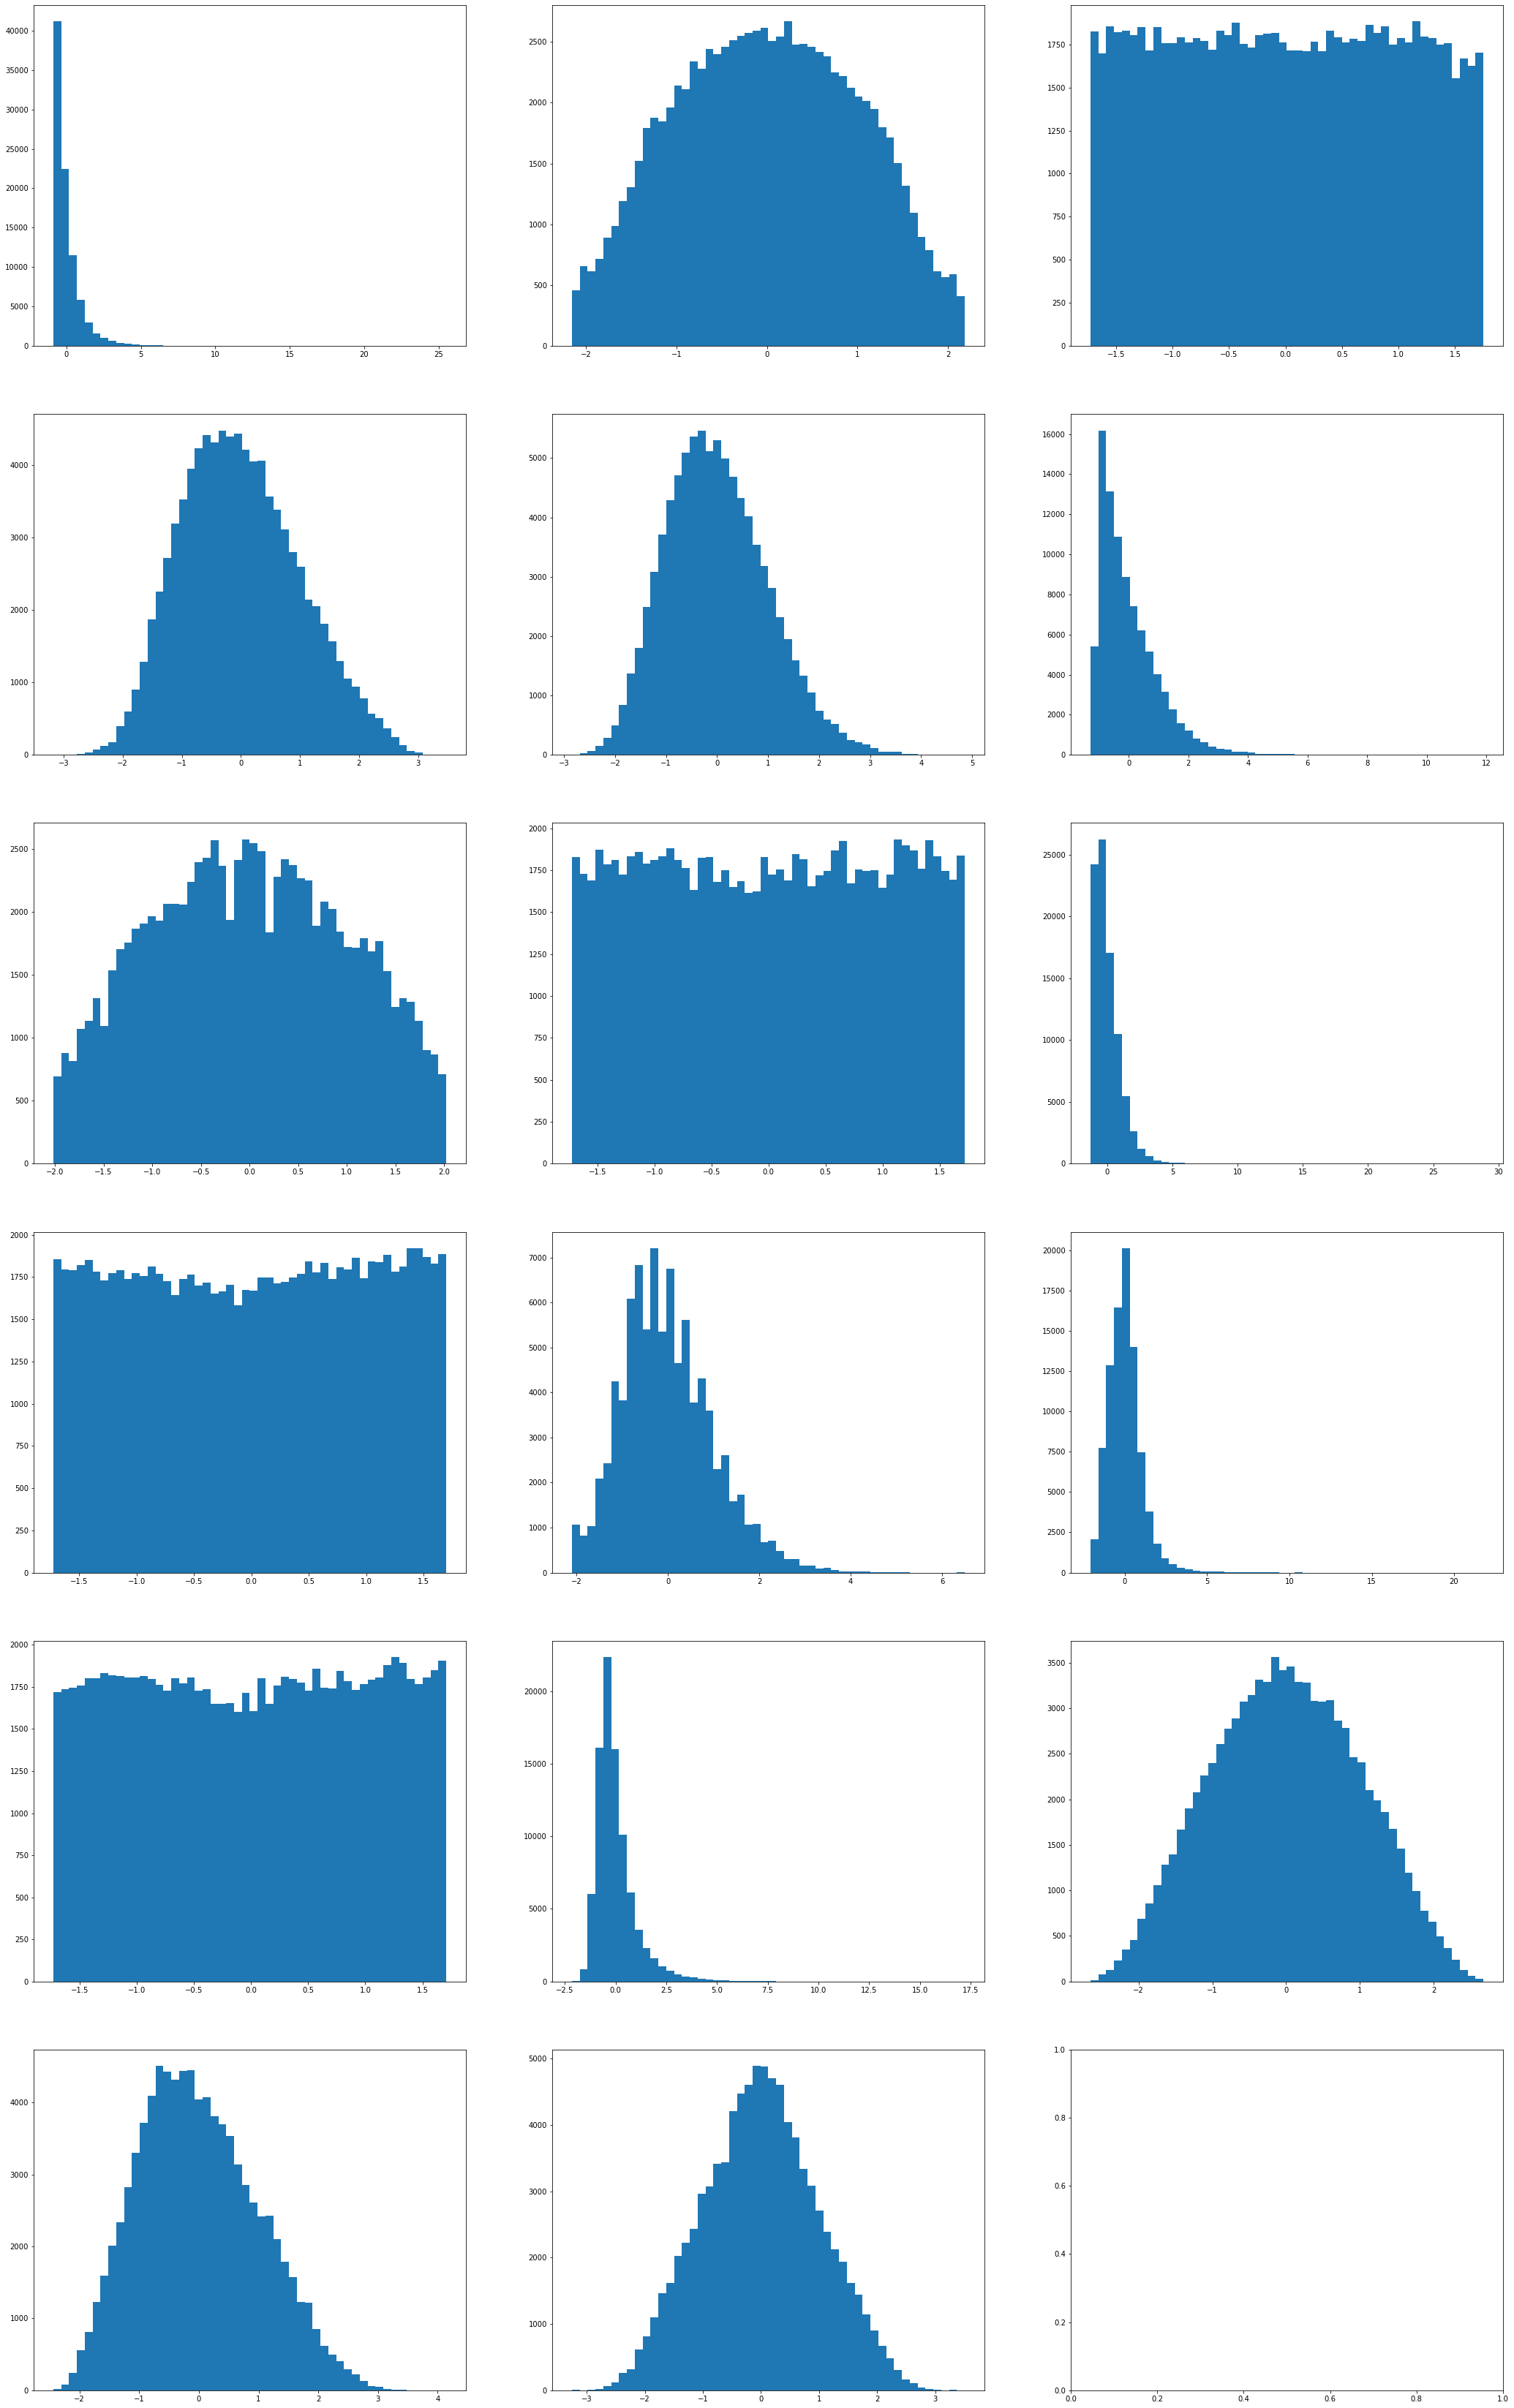

In [28]:
nvars = X_train_scaled.shape[1]
ncols = 3
nrows = ( nvars // ncols ) if nvars % ncols == 0 else ( nvars // ncols + 1 )

fig, axes = plt.subplots( nrows, ncols, figsize=( ncols * 12, nrows * 10 ) )

idx_row = 0
idx_col = 0
for idx_ in range( nvars ):
    arr_ = X_train_scaled[ :, idx_ ]
    axes[ idx_row, idx_col ].hist( arr_, bins=50 )
    idx_col += 1
    if idx_col == ncols:
        idx_row += 1
        idx_col = 0

### Model build function

In [43]:
# def build_model(input_shape=X_train_scaled.shape[1:], learning_rate=5e-4, n_hidden=1, n_neurons=50, dropout=0.20 ):
#     print( "Building model with:" )
#     print( "Number of hidden layers: {}".format(n_hidden) )
#     print( "Number of neurons per layer: {}".format(n_neurons) )
#     print( "Learning rate: {}".format(learning_rate) )
#     print( "Input shape: {}".format(input_shape) )
#     print( "Dropout rate: {}".format(dropout) )
    
#     model = keras.models.Sequential()
#     model.add( keras.layers.InputLayer(input_shape=input_shape) )
#     for layer in range(n_hidden):
#         if dropout > 0.:
#             model.add( keras.layers.Dropout(rate=dropout) )
#         model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
#     if dropout > 0.:
#         model.add( keras.layers.Dropout(rate=dropout) )    
#     model.add( keras.layers.Dense(1, activation="sigmoid") )
    
#     #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
#     optimizer = keras.optimizers.Nadam(lr=learning_rate)
#     model.compile( loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
#     return model

In [44]:
from keras_model import Model, build_model

### Define training callbacks

In [30]:
def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

In [31]:
def callbacks(patience=10, log_dir=""):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )
        
    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )
    
    return callbacks_

In [32]:
log_dir="keras_logs"
callbacks_ = callbacks(patience=5, log_dir=log_dir)
callbacks_

Log dir: keras_logs/run_2021_04_16-23_36_57


### Build model (example)

In [33]:
model = build_model(
    input_shape=X_train_scaled.shape[1:],
    learning_rate=1e-4,
    n_hidden=1,
    n_neurons=50,
    dropout=0.20
    )
model.summary()

Building model with:
Number of hidden layers: 1
Number of neurons per layer: 50
Learning rate: 0.0001
Input shape: (17,)
Dropout rate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 17)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                900       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [34]:
fit_example = False

if fit_example:
    history = model.fit( X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
    print( history.history )

    pd.DataFrame( history.history ).plot( figsize=(12,10) )

### Evaluate on training data (without dropout)

In [35]:
if fit_example:
    model.evaluate( X_train_scaled, y_train )

### Evaluate on test data

In [36]:
if fit_example:
    model.evaluate( X_test_scaled, y_test )

    y_test_proba = model.predict( X_test_scaled )
    print ( y_test_proba.shape )
    y_test_proba

### Scan over different learning rates

In [37]:
def find_max_learning_rate( lr_init=1e-4, lr_end=5e-2, steps=20, epochs=20, model_build_fn=build_model, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callbacks(patience=5)
        history_ = model_.fit( X_train_scaled, y_train, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_
        
    return results_

In [38]:
epochs_lr_scan=20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                lr_init=1e-4,
                lr_end=2e-2,
                steps=10,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                input_shape=X_train_scaled.shape[1:],
                n_hidden=1,
                n_neurons=20,
                dropout=0.20,
                )

In [39]:
if learning_rate_scan:
    metrics_ = 'val_loss'
    columns=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)] 
    df = pd.DataFrame( np.full((epochs_lr_scan,len(columns)),np.nan), columns=columns )
    for i_lr_,col_ in enumerate(columns):
        df[col_] = pd.Series( results[ metrics_ ][i_lr_] )
    df.plot( figsize=(12,10) )
    plt.yscale('log')
    plt.show()

### Hyperparameter scan

In [45]:
learning_rate = 5e-4

n_iter_search = 3
epochs_grid_search = 20

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()
        
    from sklearn.model_selection import RandomizedSearchCV
    #from sklearn.model_selection import GridSearchCV

#     def build_fn_(n_hidden, n_neurons, dropout):
#         return build_model(X_train_scaled.shape[1:], learning_rate, n_hidden, n_neurons, dropout=dropout)
    build_fn_ = Model( input_shape=X_train_scaled.shape[1:], learning_rate=learning_rate )
    keras_clf = keras.wrappers.scikit_learn.KerasClassifier( build_fn_ )

#     #param_grid = [
#     #    { "n_hidden": [2],
#     #      "n_neurons": [50,100] }
#     #    ]
#     param_grid = [
#         { "n_hidden": np.arange(1,3),
#           "n_neurons": [20,50] }
#         ]

    param_distribs = {
        "n_hidden": np.arange(2,6),
        "n_neurons": 2 ** np.arange(4,8),
        "dropout":  0.1 * np.arange(2,6),
        "batch_size": 2 ** np.arange(5,8)
        }

    #grid_search = GridSearchCV( keras_clf, param_grid, cv=3, scoring='f1', refit=False )
    
    grid_search = RandomizedSearchCV(
        keras_clf,
        param_distribs,
        n_iter=n_iter_search, cv=4, verbose=20, n_jobs=-1, scoring='f1', refit=False, random_state=42
        )

    callbacks_ = callbacks(patience=5)
    print ( callbacks_ )
    grid_search.fit( X_train_scaled, y_train, epochs=epochs_grid_search, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
    
    print ( grid_search.best_params_ )
    print ( grid_search.best_score_ )
    print ( grid_search.cv_results_ )
    
    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/16 23:43:32
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:  4.1min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  4.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  4.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  6.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.3min remaining:  1.3min


{'n_neurons': 16, 'n_hidden': 5, 'dropout': 0.2, 'batch_size': 64}
0.8491916333216531
{'mean_fit_time': array([188.74133861,  59.88337737, 114.62412918]), 'std_fit_time': array([18.23212975,  1.79047519, 11.00809282]), 'mean_score_time': array([1.64691067, 0.70020562, 0.75922328]), 'std_score_time': array([0.25837145, 0.05140725, 0.38260334]), 'param_n_neurons': masked_array(data=[32, 16, 16],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_n_hidden': masked_array(data=[5, 4, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_dropout': masked_array(data=[0.4, 0.2, 0.2],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_batch_size': masked_array(data=[32, 128, 64],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neurons': 32, 'n_hidden': 5, 'dropout': 0.4, 'batch_size': 32}, {'n_neur

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished


### Build model

In [46]:
model_final = None

if train_model:
    params = {'n_hidden': 1, 'n_neurons': 50, 'dropout': 0.20}
    batch_size = 32
    if run_grid_search: 
        params = grid_search.best_params_.copy()
        batch_size = params[ 'batch_size' ]
        params.pop( 'batch_size' )
    print ( params, "batch_size: {}".format( batch_size ) )
    
    model_final = build_model(input_shape=X_train_scaled.shape[1:], learning_rate=learning_rate, **params )
    model_final.summary()
    log_dir="keras_logs"
    callbacks_ = callbacks(patience=5, log_dir=log_dir)
    print ( callbacks_ )
    model_final.fit( X_train_scaled, y_train, epochs=100, batch_size=batch_size, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_ )
else:
    model_final = keras.models.load_model( model_path )
    
model_final.summary()

{'n_neurons': 16, 'n_hidden': 5, 'dropout': 0.2} batch_size: 64
Building model with:
Input shape: (17,)
Learning rate: 0.0005
Number of hidden layers: 5
Number of neurons per layer: 16
Dropout rate: 0.2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                288       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________

W0416 23:52:57.595215 140005852895040 deprecation.py:317] From /eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


   2/1386 [..............................] - ETA: 8:21 - loss: 1.1050 - accuracy: 0.5000

W0416 23:52:58.303276 140005852895040 callbacks.py:325] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.7095s). Check your callbacks.


1386/1386 [==============================] - 4s 3ms/step - loss: 0.1593 - accuracy: 0.9542 - val_loss: 0.0530 - val_accuracy: 0.9844
Epoch 2/100
1386/1386 [==============================] - 3s 2ms/step - loss: 0.0666 - accuracy: 0.9852 - val_loss: 0.0348 - val_accuracy: 0.9844
Epoch 3/100
1386/1386 [==============================] - 3s 2ms/step - loss: 0.0530 - accuracy: 0.9854 - val_loss: 0.0257 - val_accuracy: 0.9898
Epoch 4/100
1386/1386 [==============================] - 3s 2ms/step - loss: 0.0447 - accuracy: 0.9868 - val_loss: 0.0195 - val_accuracy: 0.9937
Epoch 5/100
1386/1386 [==============================] - 3s 2ms/step - loss: 0.0402 - accuracy: 0.9880 - val_loss: 0.0168 - val_accuracy: 0.9945
Epoch 6/100
1386/1386 [==============================] - 3s 2ms/step - loss: 0.0367 - accuracy: 0.9888 - val_loss: 0.0154 - val_accuracy: 0.9950
Epoch 7/100
1386/1386 [==============================] - 3s 2ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0129 - val_accuracy: 0.99

In [47]:
model_final.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 17),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_2'}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_2',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 16,
    'activation': 'elu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_3',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
 

### Evaluate on training data (without dropout)

In [48]:
model_final.evaluate( X_train_scaled, y_train )

2771/2771 [==============================] - 4s 1ms/step - loss: 0.0123 - accuracy: 0.9968


[0.012301169335842133, 0.9968422651290894]

### Re-evaluate on validation data 

In [49]:
model_final.evaluate( X_valid_scaled, y_valid )

693/693 [==============================] - 1s 1ms/step - loss: 0.0129 - accuracy: 0.9963


[0.012866032309830189, 0.996300995349884]

### Evaluate on test data

In [50]:
model_final.evaluate( X_test_scaled, y_test )

y_test_proba = model_final.predict( X_test_scaled )
y_test_proba

2310/2310 [==============================] - 3s 1ms/step - loss: 0.0118 - accuracy: 0.9972


array([[8.6795914e-01],
       [7.7934718e-01],
       [2.8622699e-01],
       ...,
       [6.8589747e-03],
       [3.4144521e-04],
       [7.4753989e-06]], dtype=float32)

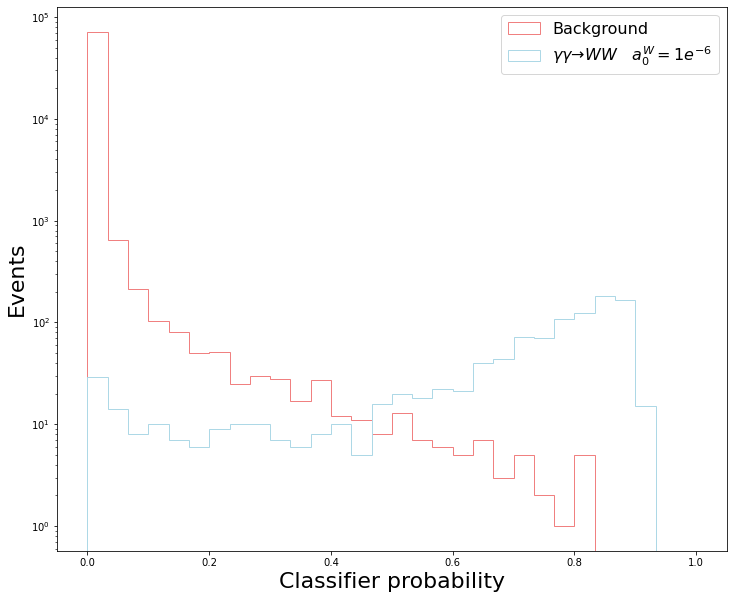

In [51]:
fig = plt.figure( figsize=(12,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='lightcoral', bins=30, range=(0.,1.), label="Background" )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='lightblue', bins=30, range=(0.,1.), label=r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$" )
plt.yscale('log')
plt.xlabel( "Classifier probability", fontsize=22 )
plt.ylabel( "Events", fontsize=22 )
plt.legend( loc='best', fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

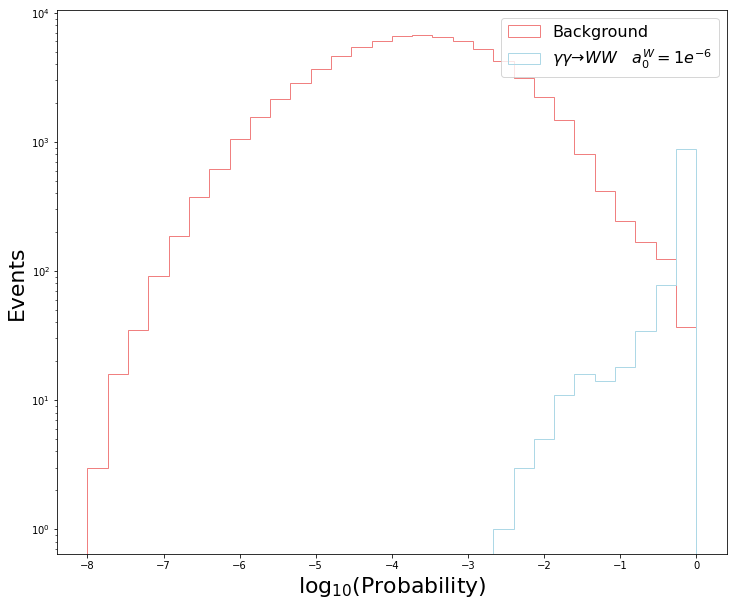

In [52]:
fig = plt.figure( figsize=(12,10) )
plt.hist( np.log10( y_test_proba[ y_test == 0 ] ), histtype='step', color='lightcoral', bins=30, range=(-8.,0.), label="Background" )
plt.hist( np.log10( y_test_proba[ y_test == 1 ] ), histtype='step', color='lightblue', bins=30, range=(-8.,0.), label=r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$" )
plt.yscale('log')
plt.xlabel( r"$\log_{10}(\rm{Probability})$", fontsize=22 )
plt.ylabel( "Events", fontsize=22 )
plt.legend( loc='best', fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_log_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_log_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

### ROC curve

[0.         0.         0.         ... 0.99368418 0.99371164 1.        ] [0.00000000e+00 9.42507069e-04 3.91140434e-01 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [1.9082614e+00 9.0826142e-01 8.2026613e-01 ... 2.6786367e-07 2.6729589e-07
 5.9163217e-09]


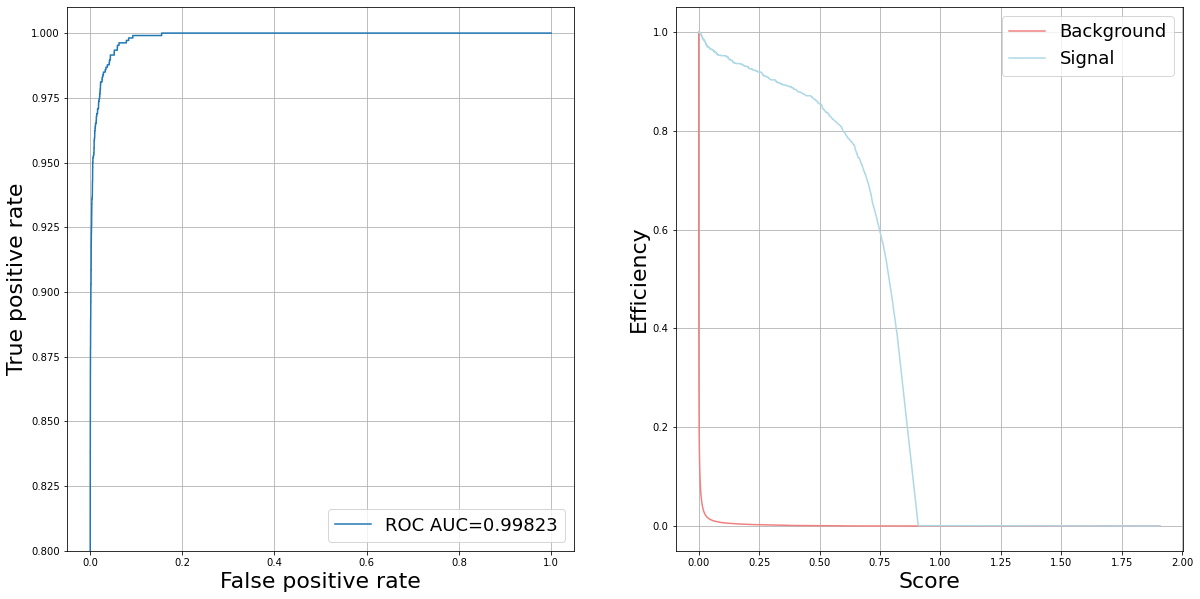

In [54]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve( y_test, y_test_proba )
auc = roc_auc_score(y_test, y_test_proba)

print ( fpr, tpr, thresholds )

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

axes[0].plot(fpr, tpr, label="ROC AUC={:.5f}".format(auc))
axes[0].legend( loc='best', fontsize=18 )
axes[0].set_xlabel( 'False positive rate', fontsize=22 )
axes[0].set_ylabel( 'True positive rate', fontsize=22 )
axes[0].set_ylim(0.80,1.01)
axes[0].grid()

#axes[0].plot(tpr,
#             np.divide(np.ones_like(fpr), fpr, out=np.zeros_like(fpr), where=fpr!=0), 
#             label="ROC AUC={:.5f}".format(auc))
#axes[0].legend(loc='best')
#axes[0].set_ylabel('Background rejection (1/false positive rate)')
#axes[0].set_xlabel('Signal efficiency (true positive rate)')
#axes[0].set_xlim(0.88,1.0)
#axes[0].grid()

axes[1].plot(thresholds,fpr,label='Background', color='lightcoral')
axes[1].plot(thresholds,tpr,label='Signal', color='lightblue')
axes[1].legend( loc='best', fontsize=18 )
axes[1].set_xlabel( 'Score', fontsize=22 )
axes[1].set_ylabel( 'Efficiency', fontsize=22 )
axes[1].grid()
#axes[1].set_xscale('log')
#axes[1].set_yscale('log')

if save_figures:
    plt.savefig( "plots/ANN-Keras_ROC_Efficiency_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_ROC_Efficiency_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

0.3196662
[1 1 0 ... 0 0 0]
0.9966438411779035
0.9000942507068803
0.9980503343264729
0.0019496656735270568
$\rm{Prob.} \geq 0.32 \;\rm{-}\; \rm{FPR} = 0.00195 \;\rm{-}\; \rm{TPR} = 0.9001$


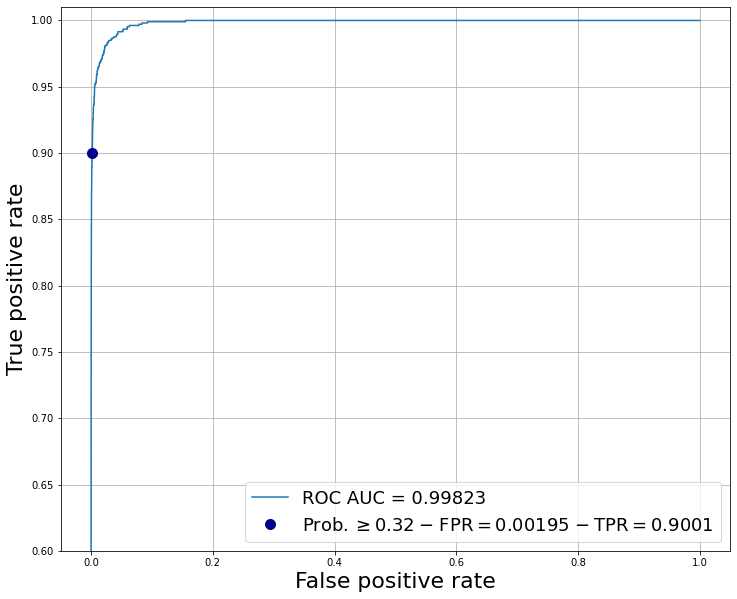

In [55]:
#prob_cut = 0.10

#tpr_target = 0.95
tpr_target = 0.90
#tpr_target = 0.85
#tpr_target = 0.70
prob_cut = thresholds[ np.argmax( tpr >= tpr_target ) ]
#fpr_target = 5.5e-04
#prob_cut = thresholds[ np.argmin( fpr <= fpr_target ) - 1 ]
print( prob_cut )

y_test_pred = ( y_test_proba >= prob_cut ).astype( "int32" )
y_test_pred = y_test_pred.ravel()
print ( y_test_pred )

from sklearn.metrics import accuracy_score
print ( accuracy_score( y_test, y_test_pred ) )
#tpr_cut = np.sum( ( y_test == 1 ) & ( y_test_pred == 1 ) ) / np.sum( ( y_test == 1 ) )
tpr_cut = accuracy_score( y_test[ y_test == 1 ], y_test_pred[ y_test == 1 ] )
print ( tpr_cut )
#tnr_cut = np.sum( ( y_test == 0 ) & ( y_test_pred == 0 ) ) / np.sum( ( y_test == 0 ) )
tnr_cut = accuracy_score( y_test[ y_test == 0 ], y_test_pred[ y_test == 0 ] )
print ( tnr_cut )
fpr_cut = ( 1. - tnr_cut )
print ( fpr_cut )

fig = plt.figure( figsize=(12,10) )
plt.plot(fpr, tpr, label="ROC AUC = {:.5f}".format(auc))
label_str = "$\\rm{{Prob.}} \geq {:.2f} \;\\rm{{-}}\; \\rm{{FPR}} = {:.5f} \;\\rm{{-}}\; \\rm{{TPR}} = {:.4f}$".format( prob_cut, fpr_cut, tpr_cut )
print ( label_str )
plt.plot( fpr_cut, tpr_cut, marker='o', markersize=10, linestyle='', color='darkblue',
          label=r"{}".format( label_str ) )
plt.legend( loc='best', fontsize=18 )
plt.xlabel( 'False positive rate', fontsize=22 )
plt.ylabel( 'True positive rate', fontsize=22 )
plt.ylim(0.60,1.01)
plt.grid()

if save_figures:
    plt.savefig( "plots/ANN-Keras_ROC_90pct_Point_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_ROC_90pct_Point_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

### Save model

In [56]:
if train_model and save_model:
    model_final.save( "model/keras_model.h5" )

### References

In [ ]:
help( keras.models.Sequential )

In [ ]:
help( keras.wrappers.scikit_learn.KerasClassifier )